In [1]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM,GRU
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D,MaxPooling1D,GlobalAveragePooling1D,Reshape
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
from sklearn.metrics import confusion_matrix, roc_auc_score,precision_recall_curve
from sklearn.metrics import classification_report,auc

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Using TensorFlow backend.


Python:  3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
pandas:  0.23.4
numpy:  1.19.1
seaborn:  0.9.0
matplotlib:  2.2.3
sklearn:  0.19.2
Keras:  2.3.1
Tensorflow:  2.1.0


In [2]:
df = pd.read_csv("../data/Twitter_volume_UPS.txt", sep=",", index_col=None)
print(df.shape)
pd.options.display.max_columns = None
df.head(5)


(15866, 2)


,timestamp,value
0,2015-02-26 21:42:53,2
1,2015-02-26 21:47:53,2
2,2015-02-26 21:52:53,4
3,2015-02-26 21:57:53,3
4,2015-02-26 22:02:53,5


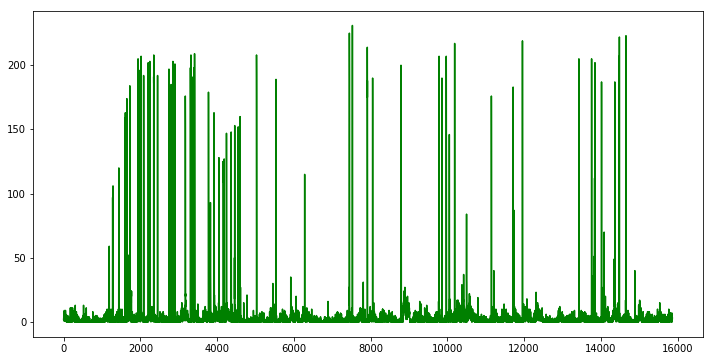

In [3]:
data=df['value']

plt.figure(figsize=(12,6))
plt.plot(data,color="green")

In [3]:
train=df[df['value']<100]
train=train['value']
train=np.array(train)
timesquence=10
trim=len(train)%timesquence
train=train[:len(train)-trim]
train.shape=(int(len(train)/timesquence),timesquence,1)
print("train",train.shape)

train (1561, 10, 1)


In [4]:
test=df['value']
test=test[1:3000]
test_label=[]

for i in range(len(test)):
    if(test.iloc[i]>100 ):
        test_label.append(1)
    else:
        test_label.append(0)
            
print(len(test_label))
test=np.array(test)
trim=len(test)%timesquence
test_label=test_label[:len(test)-trim]
test=test[:len(test)-trim]
test.shape=(int(len(test)/timesquence),timesquence,1)
print("test",test.shape)

2999
test (299, 10, 1)


In [17]:
LSTM

metric = 'mean_absolute_error'
model = Sequential()
model.add(LSTM(units=32, activation='relu', input_shape=(timesquence, 1), return_sequences=True))
#model.add(LSTM(units=16, activation='relu', input_shape=(timesquence, 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))
 
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 32)            4352      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 10, 1)             33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
metric = 'mean_absolute_error'
model = Sequential()
model.add(GRU(units=32, activation='relu', input_shape=(timesquence, 1), return_sequences=True))
model.add(GRU(units=16,activation='relu', return_sequences=True))
model.add(GRU(units=8,activation='relu', return_sequences=True))
model.add(Dropout(0.5))  
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 10, 32)            3264      
_________________________________________________________________
gru_2 (GRU)                  (None, 10, 16)            2352      
_________________________________________________________________
gru_3 (GRU)                  (None, 10, 8)             600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 8)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10, 1)             9         
Total params: 6,225
Trainable params: 6,225
Non-trainable params: 0
_________________________________________________________________
None


In [107]:
from keras.layers import  Lambda
n_filters = 32 
filter_width = 2

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq
x = Conv1D(filters=n_filters,
               kernel_size=filter_width,
             padding='causal',
              activation='relu')(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)
# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]
pred_seq_train = Lambda(slice, arguments={'seq_length':timesquence})(x)

model = Model(history_seq, pred_seq_train)
model.compile(optimizer=optimizers.Adam(), loss='mean_absolute_error')
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
dense_4 (Dense)              (None, None, 128)         4224      
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           129       
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 1)           0         
Total params: 4,449
Trainable params: 4,449
Non-trainable params: 0
_________________________________________________________

In [56]:

history=model.fit(train, train,
                  batch_size=256,#64#64
                   epochs=6,#10,11
                    validation_data=(test, test))



Train on 1561 samples, validate on 299 samples
Epoch 1/6
1561/1561 [==============================] - 3s 2ms/step - loss: 2.8376 - val_loss: 6.3833
Epoch 2/6
1561/1561 [==============================] - 0s 121us/step - loss: 2.0284 - val_loss: 4.1346
Epoch 3/6
1561/1561 [==============================] - 0s 121us/step - loss: 1.3388 - val_loss: 2.2110
Epoch 4/6
1561/1561 [==============================] - 0s 123us/step - loss: 0.9606 - val_loss: 1.5826
Epoch 5/6
1561/1561 [==============================] - 0s 116us/step - loss: 0.8522 - val_loss: 1.3402
Epoch 6/6
1561/1561 [==============================] - 0s 122us/step - loss: 0.6486 - val_loss: 0.8007


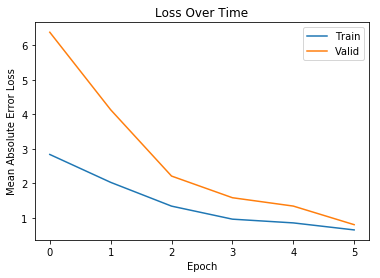

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [58]:
test_pred = model.predict(test)
print(test_pred.shape)
# print(test[0:5])
# print("-------------------------")
# print(test_pred[0:5])


(299, 10, 1)


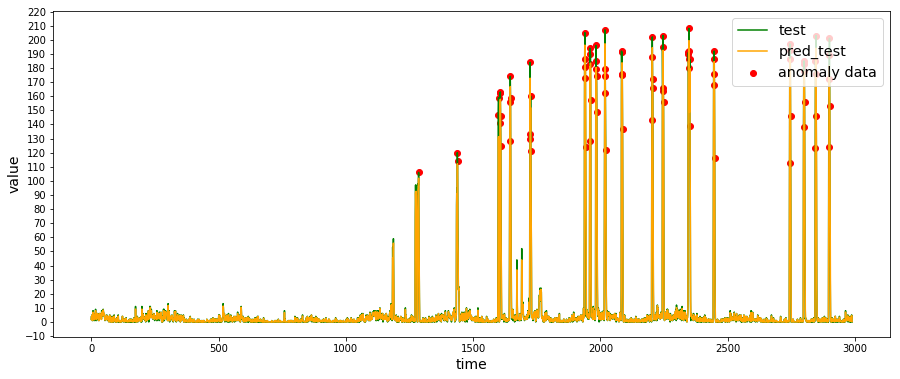

In [95]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(10)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,2)
plt.plot(test1[0:],color="green")
plt.plot(test_pred1[0:],color="orange",linestyle='-')

for i in range(len(test1)):
    if test_label[i] == 1:
        plt.scatter(i,test1[i],color="red")          
plt.legend(('test','pred_test','anomaly data'),loc='upper right',fontsize='x-large')


In [120]:
#点集检测
pred_label=[]
for i in range(len(test1)):
    pred_label.append(0)#正常

PAsum_rela_erro=np.zeros((len(pred_label)), dtype = float)
for i in range(len(pred_label)):
    PAsum_rela_erro[i]=np.abs(test1[i]-test_pred1[i])
PAscores=PAsum_rela_erro.copy()
PAscores.sort()
print(PAscores)


[4.27341461e-03 4.27341461e-03 4.27341461e-03 ... 3.29004555e+01
 3.34885559e+01 3.50562592e+01]


In [109]:
print(PAscores[500])

0.06769763678312302


In [121]:
PAcutoff=int(0.96*len(PAscores))#966
PAthreshold=PAscores[PAcutoff]
print(PAscores[PAcutoff])

4.1264495849609375


In [122]:
for i in range(len(test1)):
    if PAsum_rela_erro[i] > PAthreshold:
        pred_label[i]=2 #异常

In [123]:
normal_rela_erro=0.15
#集体集检测
timestep=3
n=int(len(pred_label)/timestep)
CAsum_rela_erro=np.zeros(n+1, dtype = float)
for i in range(0,len(test1),timestep):
    for j in range(timestep):
            if ((i+j)<len(pred_label)) and (pred_label[i+j]==0):
                rela_erro=np.abs(test1[i+j]-test_pred1[i+j])
                CAsum_rela_erro[int(i/timestep)]=rela_erro+CAsum_rela_erro[int(i/timestep)]
              #  print()
            else:
                CAsum_rela_erro[int(i/timestep)]=normal_rela_erro+CAsum_rela_erro[int(i/timestep)]
                
                
CAscores=CAsum_rela_erro.copy()
CAscores.sort()
print(CAscores)


[ 0.01282024  0.14227319  0.15554464  0.15576309  0.173985    0.173985
  0.18725704  0.18734425  0.1874755   0.18911052  0.18986213  0.20269918
  0.20269918  0.20269918  0.20283043  0.20296167  0.20296167  0.20309291
  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291
  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291
  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291
  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291
  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291
  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291
  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291
  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291
  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291
  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291  0.20309291
  0.20309291  0.20309291  0.20309291  0.20309291  0.2

In [124]:
CAcutoff=int(0.99*len(CAscores))#0.996
CAthreshold=CAscores[CAcutoff]
print(CAthreshold)

5.24222412109375


In [125]:
for i in range(n+1):
    if CAsum_rela_erro[i] > CAthreshold:
        for j in range(timestep):
            if i*timestep+j<len(pred_label) and pred_label[i*timestep+j]!=2:
                pred_label[i*timestep+j]=1
        

In [126]:
Perro_x=[]
Perro_y=[]
Cerro_x=[]
Cerro_y=[]
for i in range(len(test1)):
    if pred_label[i]==2:
        Perro_x.append(i)
        Perro_y.append(test1[i])
    elif pred_label[i]==1:
        Cerro_x.append(i)
        Cerro_y.append(test1[i])

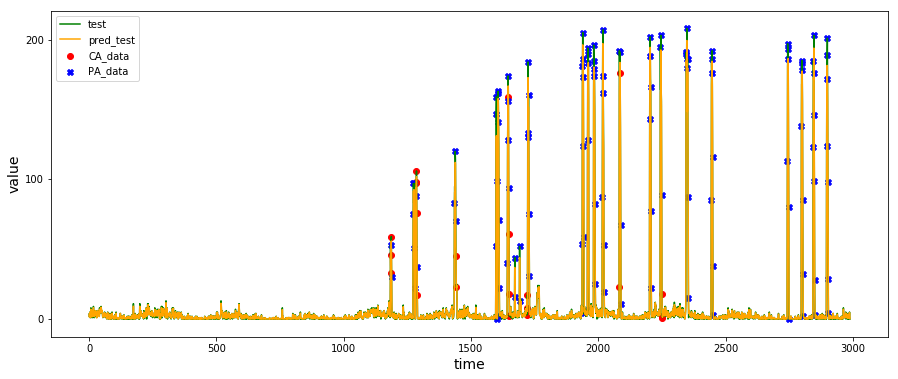

In [127]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,1000)
plt.plot(test1[0:],color="green",label='test')
plt.plot(test_pred1[0:],color="orange",linestyle='-',label='pred_test')
plt.scatter(Cerro_x,Cerro_y,color="red",label='CA_data')
plt.scatter(Perro_x,Perro_y,color="blue",marker="X",label='PA_data')          
plt.legend()


In [128]:
Pred_label=[]
for i in range(len(pred_label)):
    if pred_label[i]==0:
        Pred_label.append(0)
    else:
        Pred_label.append(1)

In [129]:
print(Pred_label.count(1))
print("CA:",pred_label.count(1))
print("PA:",pred_label.count(2))
ROC=roc_auc_score(test_label,Pred_label)
print("ROC_AUC score:{:2%}".format(ROC))  
precision, recall, _thresholds = precision_recall_curve(test_label, Pred_label)
PR_AUC = auc(recall, precision)
print("PR-AUC score:{:2%}".format(PR_AUC)) 

142
CA: 23
PA: 119
ROC_AUC score:87.213980%
PR-AUC score:62.431745%


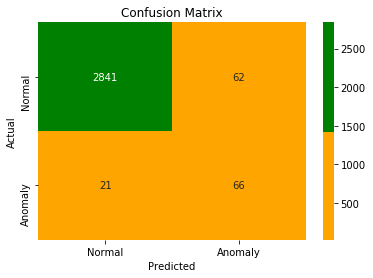

In [119]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(6, 4))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

viz = Visualization()
viz.draw_confusion_matrix(test_label,Pred_label)